In [41]:
import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions, TransitionPotential, EELSDetector
from abtem import SMatrix, Potential, GridScan

from ase import units
from ase.io import read

from typing import Union

import numpy as np
from numba import jit,vectorize,guvectorize,float64

Z = 6 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional
gpts = 1024
extent = 10
energy = 3e5
order = 2
transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=1)
# max_epsilon = energy - transitions.ionization_energy
sampling = extent/gpts
# @vectorize([float64(float64)])
def differentital_edx_potential(E):
    transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=E,order=order)
    atomic_transition_potentials = transitions.get_transition_potentials(extent = extent,
                                                                    gpts = gpts,
                                                                    energy = energy)
    if energy <= transitions.ionization_energy + E:
        return np.zeros([gpts,gpts])       
    else:                                                         
        intensity = None
        for t in atomic_transition_potentials:
            pot = t.measure().intensity().array
            if intensity is None:
                intensity = pot
            else:
                intensity += pot    
        return intensity
 

# @jit(nopython=False)
def vector_edx_potential(x_list):
    y_list = []
    for x in x_list:
        y_list.append(differentital_edx_potential(x))
    return y_list

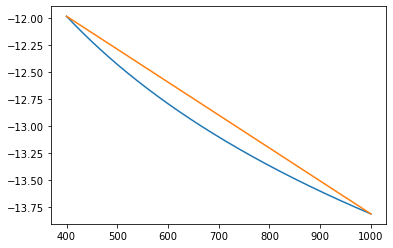

In [113]:
# plt.plot(energy_list,np.log(scs_list))

x = np.linspace(400,1000,num=10000)

y = np.log(1/(1+x**2))

plt.plot(x,y)
plt.plot([x[0],x[-1]],[y[0],y[-1]])
plt.show()

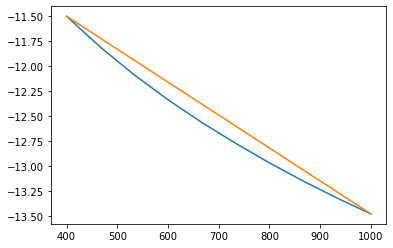

In [114]:
x = energy_list
y= np.log(scs_list)
plt.plot(energy_list,y)
plt.plot([x[0],x[-1]],[y[0],y[-1]])
plt.show()

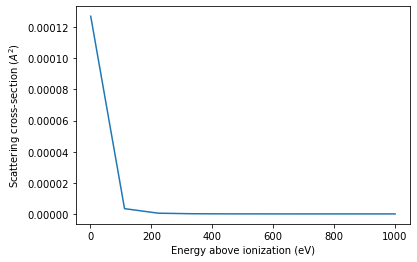

In [7]:
plt.plot(energy_list,np.dot(scs_list,sampling**2))
plt.xlabel('Energy above ionization (eV)')
plt.ylabel(r'Scattering cross-section ($A^2$)')
plt.show()

In [10]:
energy_list = np.logspace(1,1000,num=10)
scs_list = [p.sum() for p in vector_edx_potential(energy_list)]
# plt.plot(energy_list,np.log(scs_list))
# plt.show()
plt.plot(energy_list,np.dot(scs_list,sampling**2))
plt.xlabel('Energy above ionization (eV)')
plt.ylabel(r'Scattering cross-section ($A^2$)')
plt.show()


/home/zzhang/miniconda3/envs/em/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
Transitions:   0%|          | 0/27 [00:00<?, ?it/s]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1000000000000D-06   r2 =  0.8169808871479D-17
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1000000000000D-06   r2 =  0.8169808871479D-17


/home/zzhang/miniconda3/envs/em/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Transitions: 100%|██████████| 27/27 [00:02<00:00, 10.46it/s]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1000000000000D-06   r2 =  0.8169808871479D-17


TypeError: Cannot interpret '1024' as a data type

In [32]:
np.zeros([1024,1024])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sympy import *

def lag_weights_roots(n):
    x = Symbol('x')
    roots = Poly(laguerre(n, x)).all_roots()
    x_i = [float(rt.evalf(20)) for rt in roots]
    w_i = [float((rt/((n+1)*laguerre(n+1, rt))**2).evalf(20)) for rt in roots]
    return x_i, w_i

points,weights = lag_weights_roots(10)
print(points,weights)

potential_list=[np.dot(p,e) for p,e in zip(vector_edx_potential(points),np.exp(points))]
potential_weighted = [np.dot(p,w) for p,w in zip(potential_list,weights)]
pot_edx=sum(potential_weighted)
plt.imshow(pot_edx)
plt.colorbar()
pot_edx.sum()*(extent/gpts)**2

In [2]:
from typing import Union

import numpy as np
import orthopy

from quadpy.tools import scheme_from_rc
from quadpy.e1r._helpers import E1rScheme


def gauss_laguerre(n: int, alpha: Union[int, float] = 0, mode: str = "numpy"):
    """
    Gauss-Laguerre quadrature for integrals of the form

        int_0^{+inf} exp(-alpha * x) f(x) dx.
    """
    symbolic = mode != "numpy"
    rc = orthopy.e1r.RecurrenceCoefficients("monic", alpha, symbolic)

    _, a, b = np.array([rc[k] for k in range(n)]).T
    points, weights = scheme_from_rc(a, b, rc.int_1, mode=mode)

    return points,weights

points,weights = gauss_laguerre(10,alpha=1)
print(points,weights)

potential_list=[np.dot(p,e) for p,e in zip(vector_edx_potential(points),np.exp(points))]
potential_weighted = [np.dot(p,w) for p,w in zip(potential_list,weights)]
pot_edx=sum(potential_weighted)
plt.imshow(pot_edx)
plt.colorbar()
pot_edx.sum()*(extent/gpts)**2

[ 0.33452868  1.12825336  2.39586992  4.16684099  6.48735303  9.42835481
 13.10172358 17.69648757 23.57778709 31.68280097] [1.34856555e-01 3.74924341e-01 3.30247131e-01 1.31528885e-01
 2.58420642e-02 2.48964580e-03 1.09488476e-04 1.88127541e-06
 9.15268503e-09 5.50130350e-12]


Transitions: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


KeyboardInterrupt: 

In [116]:
def double_exp(N,x_min,x_max):
    t_min = np.arcsinh(2*np.log(x_min)/np.pi);
    t_max = np.arcsinh(2*np.log(x_max)/np.pi);
    h = (t_max-t_min)/N;
    t_list = np.linspace(t_min,t_max,num=N)
    points = np.exp(np.pi/2*np.sinh(t_list))
    weights =np.exp(np.pi/2*np.sinh(t_list))*np.pi/2*np.cosh(t_list)
    return points, weights

points,weights = double_exp(8,1e-7,1000)
print(points,weights)

[1.00000000e-07 5.03360782e-04 3.09189511e-02 2.52705575e-01
 9.29840501e-01 3.27999380e+00 2.30484407e+01 1.00000000e+03] [1.61944561e-06 3.90354018e-03 1.17949459e-01 5.27633533e-01
 1.46215535e+00 6.45948011e+00 8.08731755e+01 7.08410080e+03]


[1.00000000e-07 6.83924018e-04 4.15945866e-02 3.22235737e-01
 1.19838734e+00 5.01133347e+00 5.95515795e+01 1.00000000e+04] [1.11194331e-06 3.50084932e-03 1.01289961e-01 4.28449324e-01
 1.30105856e+00 7.74388055e+00 1.79026391e+02 6.41531309e+04]





Transitions: 100%|██████████| 9/9 [00:01<00:00,  6.54it/s]



Transitions: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]



Transitions: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]



Transitions: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]



Transitions: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]



Transitions: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]



Transitions: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]



Transitions:   0%|          | 0/180 [3:09:29<?, ?it/s]


0.00017867973771624904

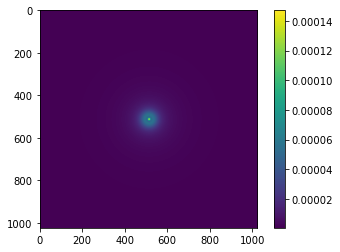

In [43]:
def double_exp(N,x_min,x_max):
    t_min = np.arcsinh(2*np.log(x_min)/np.pi);
    t_max = np.arcsinh(2*np.log(x_max)/np.pi);
    h = (t_max-t_min)/N;
    t_list = np.linspace(t_min,t_max,num=N)
    points = np.exp(np.pi/2*np.sinh(t_list))
    weights =np.exp(np.pi/2*np.sinh(t_list))*np.pi/2*np.cosh(t_list)*h
    return points, weights

points,weights = double_exp(8,1e-7,10000)
print(points,weights)

potential_list= vector_edx_potential(points)
potential_weighted = [np.dot(p,w) for p,w in zip(potential_list,weights)]
pot_edx=sum(potential_weighted)
plt.imshow(pot_edx)
plt.colorbar()
pot_edx.sum()*(extent/gpts)**2

(<AxesSubplot:xlabel=' [A]'>, <matplotlib.lines.Line2D at 0x7f784458c4f0>)

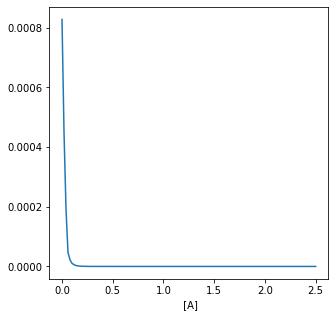

In [196]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
calibrate = Calibration(offset=0,sampling=sampling,units='A')
Measurement(pot_edx[128,128:],calibrations=calibrate).show(ax=ax)

In [51]:
v.max()/pot_edx.max()

1.346771013307655

Text(0.5, 1.0, 'C, core orbital = 1s, Energy = 50 keV')

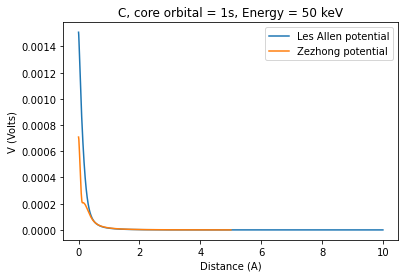

In [8]:
import scipy.io as scio

data = scio.loadmat('C_1s.mat')

r= data['r']
v = data['v']
plt.plot(r.flatten(),v.flatten(),label='Les Allen potential')
plt.plot(np.linspace(0,extent/2,num=512),pot_edx[512,512:],label='Zezhong potential')
plt.xlabel('Distance (A)')
plt.ylabel('V (Volts)')
plt.legend()
plt.title('C, core orbital = 1s, Energy = 50 keV')

Text(0.5, 1.0, 'Al, core orbital = 1s, Energy = 300 keV')

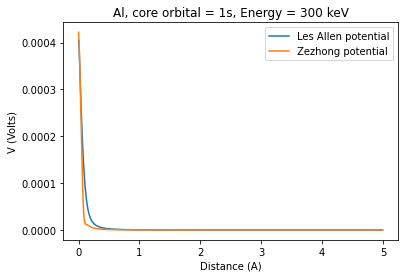

In [40]:
import scipy.io as scio

data = scio.loadmat('Al_1s.mat')

r= data['r']
v = data['v']
plt.plot(r.flatten(),v.flatten(),label='Les Allen potential')
plt.plot(np.linspace(0,extent/2,num=512),pot_edx[512,512:],label='Zezhong potential')
plt.xlabel('Distance (A)')
plt.ylabel('V (Volts)')
plt.legend()
plt.title('Al, core orbital = 1s, Energy = 300 keV')

In [31]:
from ase import units
units.m

10000000000.0

Text(0.5, 1.0, 'Au, core orbital = 2s, Energy = 300 keV')

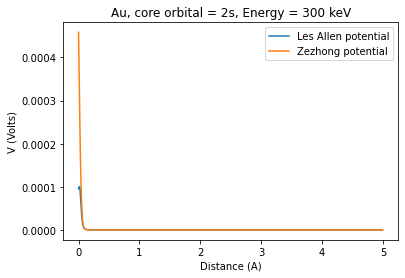

In [37]:
import scipy.io as scio

data = scio.loadmat('Au_2s.mat')

r= data['r']
v = data['v']
plt.plot(r.flatten(),v.flatten(),label='Les Allen potential')
plt.plot(np.linspace(0,extent/2,num=512),pot_edx[512,512:],label='Zezhong potential')
plt.xlabel('Distance (A)')
plt.ylabel('V (Volts)')
plt.legend()
plt.title('Au, core orbital = 2s, Energy = 300 keV')

Text(0.5, 1.0, 'Ag, core orbital = 3d, Energy = 300 keV')

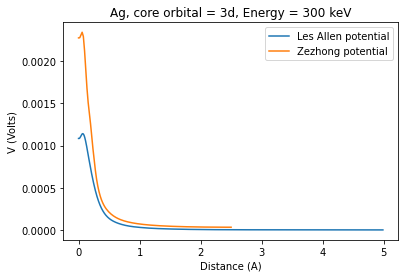

In [205]:
import scipy.io as scio

data = scio.loadmat('Ag_3d.mat')

r= data['r']
v = data['v']
plt.plot(r.flatten(),v.flatten(),label='Les Allen potential')
plt.plot(np.linspace(0,extent/2,num=512),pot_edx[512,512:],label='Zezhong potential')
plt.xlabel('Distance (A)')
plt.ylabel('V (Volts)')
plt.legend()
plt.title('Ag, core orbital = 3d, Energy = 300 keV')

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f7844105280>)

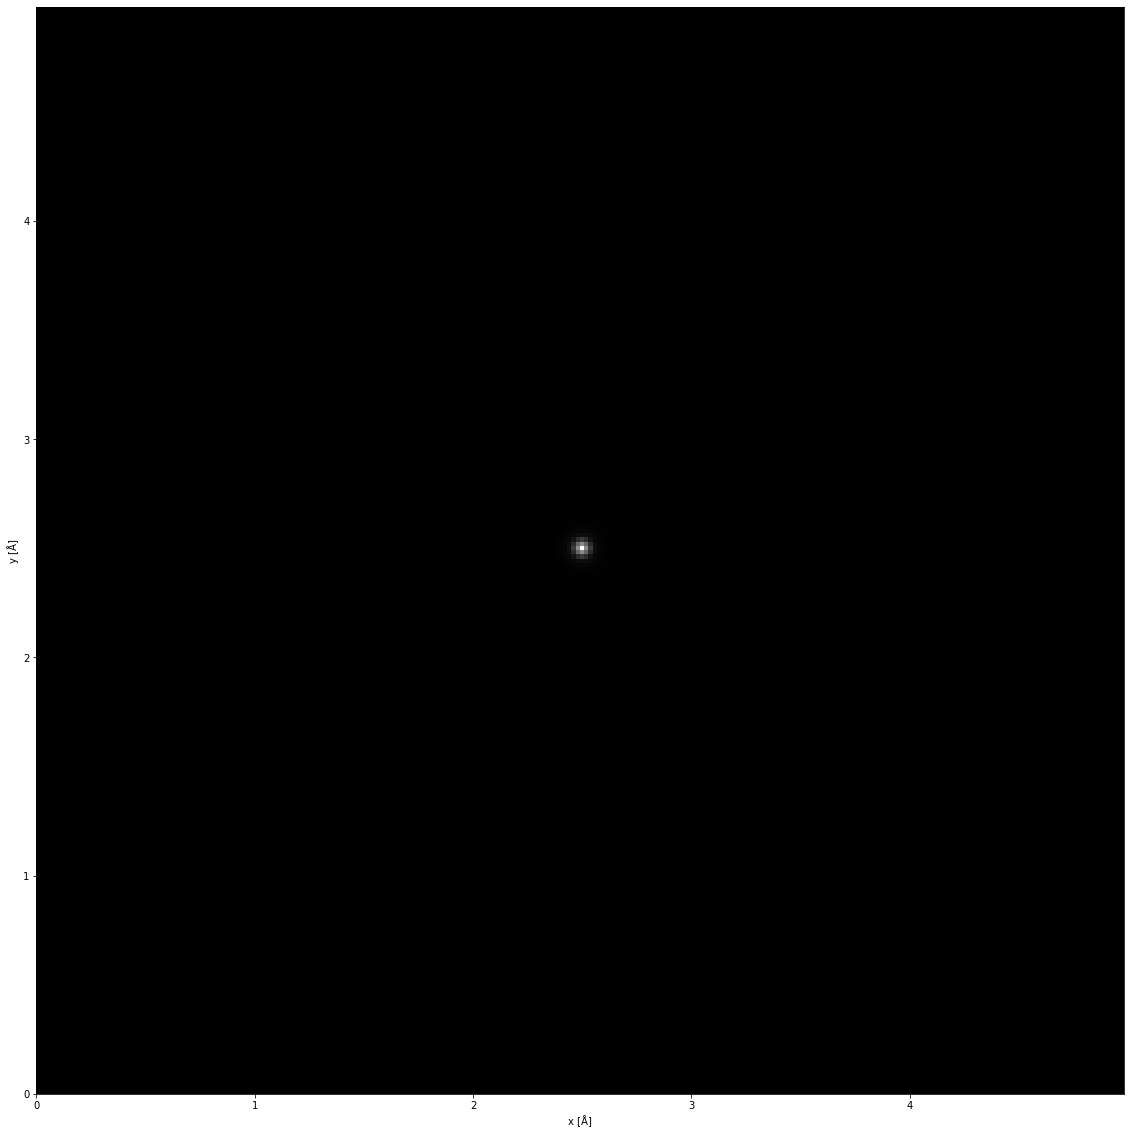

In [194]:
from abtem.measure import Calibration,Measurement,calibrations_from_grid
fig, ax = plt.subplots(1,1, figsize = (20,20))
calibrate = calibrations_from_grid(gpts=[gpts,gpts],sampling=[sampling,sampling])
Measurement(pot_edx,calibrations=calibrate).show(ax=ax)

Transitions: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


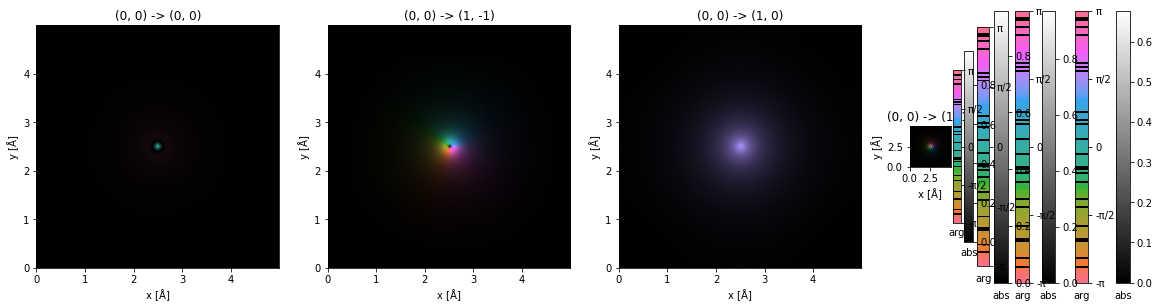

In [2]:
transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=10)
atomic_transition_potentials = transitions.get_transition_potentials(extent = 5,
                                                                sampling= 0.01,
                                                                energy = 3e5)
fig, axes = plt.subplots(1,4, figsize = (20,5))

for ax, atomic_transition_potential in zip(axes, atomic_transition_potentials):
    # print(str(atomic_transition_potential))
    atomic_transition_potential.show(ax = ax, title = str(atomic_transition_potential),cbar=True,cbar_label='Intensity')

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f786ef9cca0>)

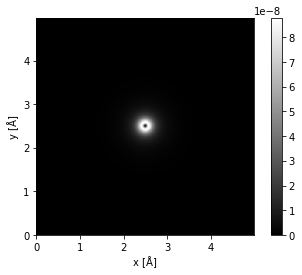

In [45]:
atomic_transition_potentials[1].measure().intensity().show(cbar=True)


0.0054328515470869814

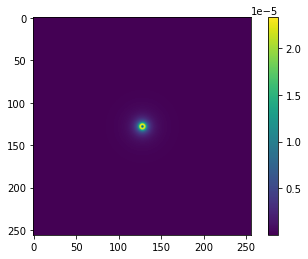

In [47]:
transitions.ionization_energy

1580.2044216562808

In [97]:
import quadpy

val, error_estimate = quadpy.c1.integrate_adaptive(vector_edx_potential,intervals=[0,300],eps_rel=1e-1)

Transitions: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


In [120]:
val*(sampling)**2

5.4475780733299545e-12

In [431]:
from abtem.visualize.utils import domain_coloring
def plot_colors(
                array,
                # extent,
                add_colorbars: bool = True,
                num_abs = 5
                ):
    from cplot._colors import get_srgb1,scale01
    from matplotlib import colors,cm
    
    plt.imshow(
        domain_coloring(array),
        # extent=extent,
        interpolation="nearest",
        origin="lower",
        aspect="equal",
    )

    if add_colorbars:
        # abs colorbar
        vmin = np.min(np.abs(array))
        vmax = np.max(np.abs(array))
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cb0 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.gray))
        cb0.set_label("abs", rotation=0, ha="center", va="top")
        cb0.ax.yaxis.set_label_coords(0.5, -0.03)
        # abs_sampling = np.linspace(vmin,vmax,num=num_abs)
        # str_abs_sampling = ["{:.1E}".format(n) for n in abs_sampling]
        # cb0.set_ticks(np.linspace(0,1,num=num_abs))
        # cb0.set_ticklabels(str_abs_sampling)

        # arg colorbar
        # create new colormap
        z = np.exp(1j * np.linspace(-np.pi, np.pi, 128))
        rgb_vals = domain_coloring(z)
        rgba_vals = np.pad(rgb_vals, ((0, 0), (0, 1)), constant_values=1.0)
        newcmp = colors.ListedColormap(rgba_vals)
        # #
        norm = colors.Normalize(vmin=-np.pi, vmax=np.pi)
        cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp))
        cb1.set_label("arg", rotation=0, ha="center", va="top")
        cb1.ax.yaxis.set_label_coords(0.5, -0.03)
        cb1.set_ticks([-np.pi, -np.pi / 2, 0, +np.pi / 2, np.pi])
        cb1.set_ticklabels(["-π", "-π/2", "0", "π/2", "π"])



In [385]:
from pyxem.utils.pixelated_stem_tools import _get_rgb_phase_magnitude_array
def make_color_wheel(ax, rotation=None):
    x, y = np.mgrid[-2.0:2.0:500j, -2.0:2.0:500j]
    r = (x ** 2 + y ** 2) ** 0.5
    t = np.arctan2(x, y)
    del x, y
    if rotation is not None:
        t += math.radians(rotation)
        t = (t + np.pi) % (2 * np.pi) - np.pi

    r_masked = np.ma.masked_where((2.0 < r) | (r < 1.0), r)
    r_masked -= 1.0

    mask = r_masked.mask
    r_masked.data[r_masked.mask] = r_masked.mean()
    rgb_array = domain_coloring(np.dot(r_masked))
    rgb_array = np.dstack((rgb_array, np.invert(mask)))

    ax.imshow(rgb_array, interpolation="quadric", origin="lower")
    ax.set_axis_off()

TypeError: dot() missing 1 required positional argument: 'b'

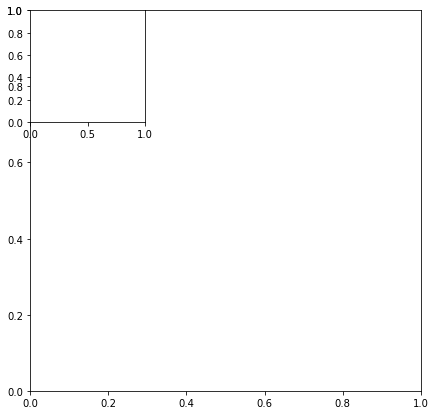

In [382]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax_indicator = fig.add_subplot(331)
make_color_wheel(ax_indicator)
plt.show()

In [433]:
atomic_transition_potentials[1].show(cbar=True)

TypeError: show() missing 1 required positional argument: 'ax'

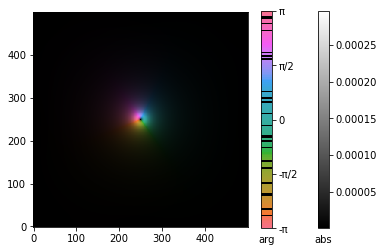

In [432]:
plot_colors(atomic_transition_potentials[1].measure().array,add_colorbars=True)

In [231]:
list(map(str, [0,33,4444522]))

['0', '33', '4444522']

In [242]:
np.array2string(np.array([1.2,3.234454,0.000346]),precision=1,separator=',')

'[1.2e+00,3.2e+00,3.5e-04]'

In [254]:
["{:.2E}".format(n) for n in np.array([1.2,3.234454,0.000346])]

['1.20E+00', '3.23E+00', '3.46E-04']

In [335]:
    rotation = None
    x, y = np.linspace(-2,2,num=100),np.linspace(-2,2,num=100)
    r = (x ** 2 + y ** 2) ** 0.5
    t = np.arctan2(x, y)
    # del x, y
    # if rotation is not None:
    #     t += math.radians(rotation)
    #     t = (t + np.pi) % (2 * np.pi) - np.pi

In [353]:
x, y = np.mgrid[-2.0:2.0:500j, -2.0:2.0:500j]
x,y
r = (x ** 2 + y ** 2) ** 0.5
t = np.arctan2(x, y)
# t += math.radians(rotation)
t = (t + np.pi) % (2 * np.pi) - np.pi

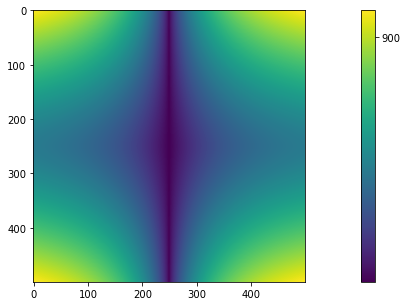

In [416]:
fig,ax = plt.subplots(1,1, figsize = (20,5))
plt.imshow(abs(np.dot(r,np.exp(1j*t))))
cb=plt.colorbar()
cb.set_ticks([900])

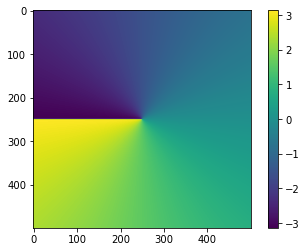

In [365]:
plt.imshow(t)
plt.colorbar()

In [ ]:
x